# Collinear spin and magnetic systems

In this example we consider iron in the BCC phase.
To show that this material is ferromagnetic we will model it once
allowing collinear spin polarization and once without
and compare the resulting SCF energies. In particular
the ground state can only be found if collinear spins are allowed.

First we setup BCC iron without spin polarization
using a single iron atom inside the unit cell.

In [1]:
using DFTK

a = 5.42352  # Bohr
lattice = a / 2 * [[-1  1  1];
                   [ 1 -1  1];
                   [ 1  1 -1]]
Fe = ElementPsp(:Fe, psp=load_psp("hgh/lda/Fe-q8.hgh"))
atoms = [Fe => [zeros(3)]];

To get the ground-state energy we use an LDA model and rather moderate
discretisation parameters.

In [2]:
kgrid = [3, 3, 3]  # k-point grid (Regular Monkhorst-Pack grid)
Ecut = 15          # kinetic energy cutoff in Hartree
model_nospin = model_LDA(lattice, atoms, temperature=0.01)
basis_nospin = PlaneWaveBasis(model_nospin; kgrid, Ecut)

scfres_nospin = self_consistent_field(basis_nospin, tol=1e-6, mixing=KerkerDosMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -16.64719020246                   -0.48    5.2
  2   -16.64774504130       -3.26       -1.01    1.0
  3   -16.64782779309       -4.08       -2.30    1.5
  4   -16.64783424320       -5.19       -2.82    4.0
  5   -16.64783430561       -7.20       -3.43    2.0


In [3]:
scfres_nospin.energies

Energy breakdown (in Ha):
    Kinetic             15.9227734
    AtomicLocal         -5.0703481
    AtomicNonlocal      -5.2213313
    Ewald               -21.4723040
    PspCorrection       1.8758831 
    Hartree             0.7796365 
    Xc                  -3.4438552
    Entropy             -0.0182886

    total               -16.647834305612

Since we did not specify any initial magnetic moment on the iron atom,
DFTK will automatically assume that a calculation with only spin-paired
electrons should be performed. As a result the obtained ground state
features no spin-polarization.

Now we repeat the calculation, but give the iron atom an initial magnetic moment.
For specifying the magnetic moment pass the desired excess of spin-up over spin-down
electrons at each centre to the `Model` and the guess density functions.
In this case we seek the state with as many spin-parallel
``d``-electrons as possible. In our pseudopotential model the 8 valence
electrons are 2 pair of ``s``-electrons, 1 pair of ``d``-electrons
and 4 unpaired ``d``-electrons giving a desired magnetic moment of `4` at the iron centre.
The structure (i.e. pair mapping and order) of the `magnetic_moments` array needs to agree
with the `atoms` array and `0` magnetic moments need to be specified as well.

In [4]:
magnetic_moments = [Fe => [4, ]];

!!! tip "Units of the magnetisation and magnetic moments in DFTK"
    Unlike all other quantities magnetisation and magnetic moments in DFTK
    are given in units of the Bohr magneton ``μ_B``, which in atomic units has the
    value ``\frac{1}{2}``. Since ``μ_B`` is (roughly) the magnetic moment of
    a single electron the advantage is that one can directly think of these
    quantities as the excess of spin-up electrons or spin-up electron density.

We repeat the calculation using the same model as before. DFTK now detects
the non-zero moment and switches to a collinear calculation.

In [5]:
model = model_LDA(lattice, atoms, magnetic_moments=magnetic_moments, temperature=0.01)
basis = PlaneWaveBasis(model; Ecut, kgrid)
ρ0 = guess_density(basis, magnetic_moments)
scfres = self_consistent_field(basis, tol=1e-6; ρ=ρ0, mixing=KerkerDosMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Magnet   Diag
---   ---------------   ---------   ---------   ------   ----
  1   -16.65997633367                   -0.51    2.620    4.5
  2   -16.66622306052       -2.20       -1.08    2.455    1.0
  3   -16.66695122115       -3.14       -2.06    2.352    2.5
  4   -16.66698989833       -4.41       -2.56    2.320    2.0
  5   -16.66699530815       -5.27       -2.88    2.307    1.5
  6   -16.66699649414       -5.93       -3.61    2.297    1.5
  7   -16.66699651923       -7.60       -3.92    2.297    3.9


In [6]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             16.3013204
    AtomicLocal         -5.2259098
    AtomicNonlocal      -5.4134764
    Ewald               -21.4723040
    PspCorrection       1.8758831 
    Hartree             0.8200950 
    Xc                  -3.5395268
    Entropy             -0.0130781

    total               -16.666996519229

!!! note "Model and magnetic moments"
    DFTK does not store the `magnetic_moments` inside the `Model`, but only uses them
    to determine the lattice symmetries. This step was taken to keep `Model`
    (which contains the physical model) independent of the details of the numerical details
    such as the initial guess for the spin density.

In direct comparison we notice the first, spin-paired calculation to be
a little higher in energy

In [7]:
println("No magnetization: ", scfres_nospin.energies.total)
println("Magnetic case:    ", scfres.energies.total)
println("Difference:       ", scfres.energies.total - scfres_nospin.energies.total);

No magnetization: -16.647834305612484
Magnetic case:    -16.6669965192285
Difference:       -0.019162213616017


Notice that with the small cutoffs we use to generate the online
documentation the calculation is far from converged.
With more realistic parameters a larger energy difference of about
0.1 Hartree is obtained.

The spin polarization in the magnetic case is visible if we
consider the occupation of the spin-up and spin-down Kohn-Sham orbitals.
Especially for the ``d``-orbitals these differ rather drastically.
For example for the first ``k``-point:

In [8]:
iup   = 1
idown = iup + length(scfres.basis.kpoints) ÷ 2
@show scfres.occupation[iup][1:7]
@show scfres.occupation[idown][1:7];

(scfres.occupation[iup])[1:7] = [1.0, 0.9999988146662814, 0.9999988146662829, 0.9999988146662823, 0.9585665145851736, 0.9585665145848764, 1.154583655949459e-29]
(scfres.occupation[idown])[1:7] = [1.0, 0.832419132210583, 0.832419132442443, 0.8324191323213522, 7.825259149700443e-6, 7.82525914969922e-6, 1.5508173983883372e-32]


Similarly the eigenvalues differ

In [9]:
@show scfres.eigenvalues[iup][1:7]
@show scfres.eigenvalues[idown][1:7];

(scfres.eigenvalues[iup])[1:7] = [-0.0692712033413344, 0.35688241296017914, 0.35688241294696565, 0.35688241295401135, 0.46192376740536123, 0.46192376740543606, 1.1596495420359498]
(scfres.eigenvalues[idown])[1:7] = [-0.03040729959554947, 0.4773085626359695, 0.4773085626193484, 0.4773085626280289, 0.6109187219334079, 0.6109187219334095, 1.225776671447982]


!!! note "k-points in collinear calculations"
    For collinear calculations the `kpoints` field of the `PlaneWaveBasis` object contains
    each ``k``-point coordinate twice, once associated with spin-up and once with down-down.
    The list first contains all spin-up ``k``-points and then all spin-down ``k``-points,
    such that `iup` and `idown` index the same ``k``-point, but differing spins.

We can observe the spin-polarization by looking at the density of states (DOS)
around the Fermi level, where the spin-up and spin-down DOS differ.

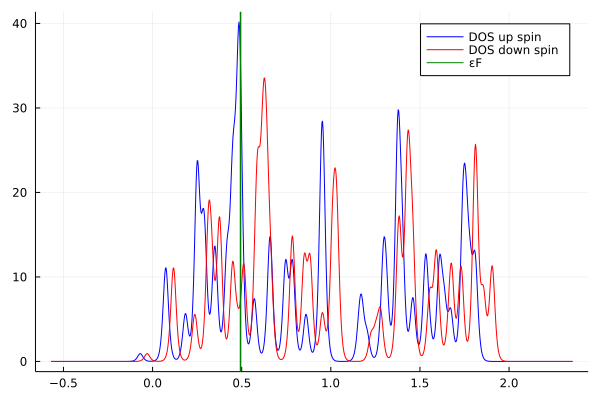

In [10]:
using Plots
plot_dos(scfres)

Similarly the band structure shows clear differences between both spin components.

Computing bands along kpath:
       Γ -> H -> N -> Γ -> P -> H  and  P -> N
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:03


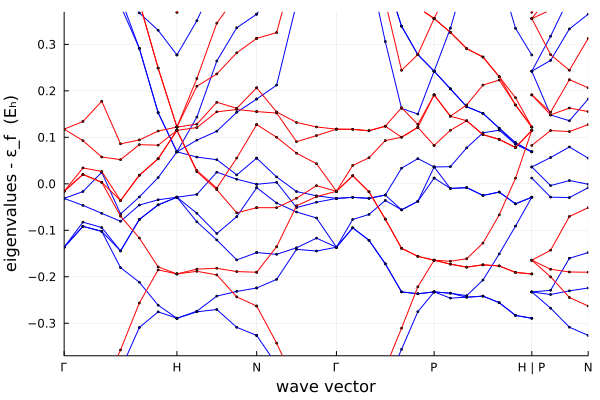

In [11]:
using Unitful
using UnitfulAtomic
plot_bandstructure(scfres; kline_density=6)